In [2]:
import pandas as pd
import numpy as np
from arch import arch_model
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [54]:
data = {}

df = pd.read_csv('C:/Projects/Revenue Scenarios/BESS_Revenue_Scenarios/raw_data/15min_data_imbalance/assets/allocation_point_1/revenue_streams.csv.csv')[["Allocation point 1 - Imbalance shortage", "Allocation point 1 - Imbalance surplus", "Unnamed: 0"]]
df_2021 = pd.read_csv('C:/Projects/Revenue Scenarios/BESS_Revenue_Scenarios/raw_data/15min_data_imbalance_2021/assets/allocation_point_1/revenue_streams.csv.csv')[["Allocation point 1 - Imbalance shortage", "Allocation point 1 - Imbalance surplus", "Unnamed: 0"]] 

# put dataframes in dictionary
data["2021"] = df_2021
data["2022"] = df

# concatenate dataframes
df = pd.concat(data.values(), ignore_index=True)

df.set_index("Unnamed: 0", inplace=True)
df.index.rename("Date", inplace=True)
df["IST"] = df["Allocation point 1 - Imbalance shortage"] + df["Allocation point 1 - Imbalance surplus"]
df.drop(columns=["Allocation point 1 - Imbalance shortage", "Allocation point 1 - Imbalance surplus"], inplace=True)

df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

df.to_csv(f"C:/Projects/Revenue Scenarios/BESS_Revenue_Scenarios/processed_data/imbalance_revenue_IST.csv", index=True)


In [ ]:
df = pd.read_csv(f"C:/Projects/Revenue Scenarios/BESS_Revenue_Scenarios/processed_data/imbalance_revenue.csv", index_col=0, parse_dates=True)


y_15 = df.IST
y_h = df.resample("h").sum()
y_d = df.resample("D").sum()
y_w = df.resample("W").sum()
y_m = df.resample("ME").sum()

imbalance_revenues = {}

imbalance_revenues["15min"] = y_15
imbalance_revenues["daily"] = y_d
imbalance_revenues["weekly"] = y_w
imbalance_revenues["monthly"] = y_m

for key in imbalance_revenues.keys():
    y = imbalance_revenues[key]
    y.plot()
    plt.title(key)
    plt.show()

    adf_test = adfuller(y)

    if( adf_test[1] > 0.05):
        print("The series is non stationary. So we take first difference.")
        y = y.diff().dropna()
    else:
        print("The series is stationary. No need to take first difference")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Plot ACF on the left subplot
    plot_acf(y, lags=20, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF on the right subplot
    plot_pacf(y, lags=20, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    fig.suptitle('ACF and PACF Plots', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()


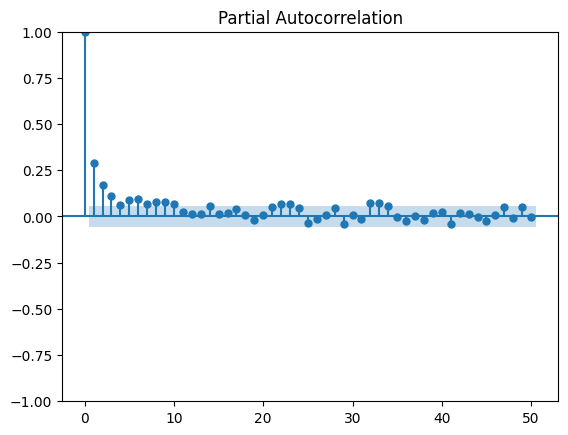

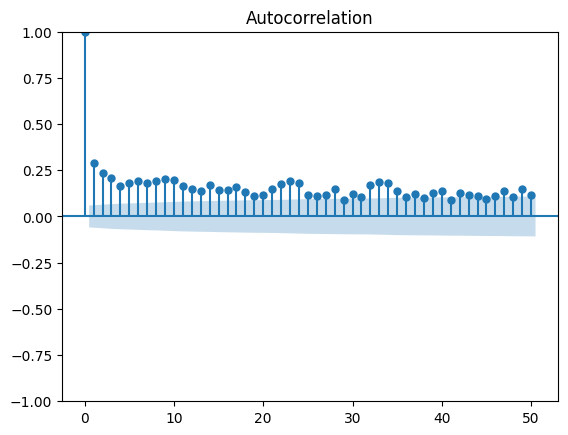

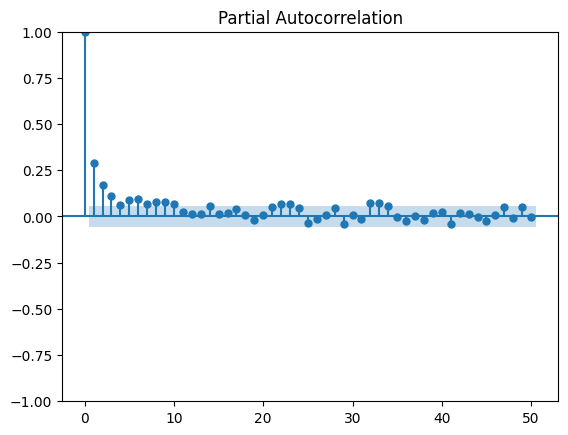

c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


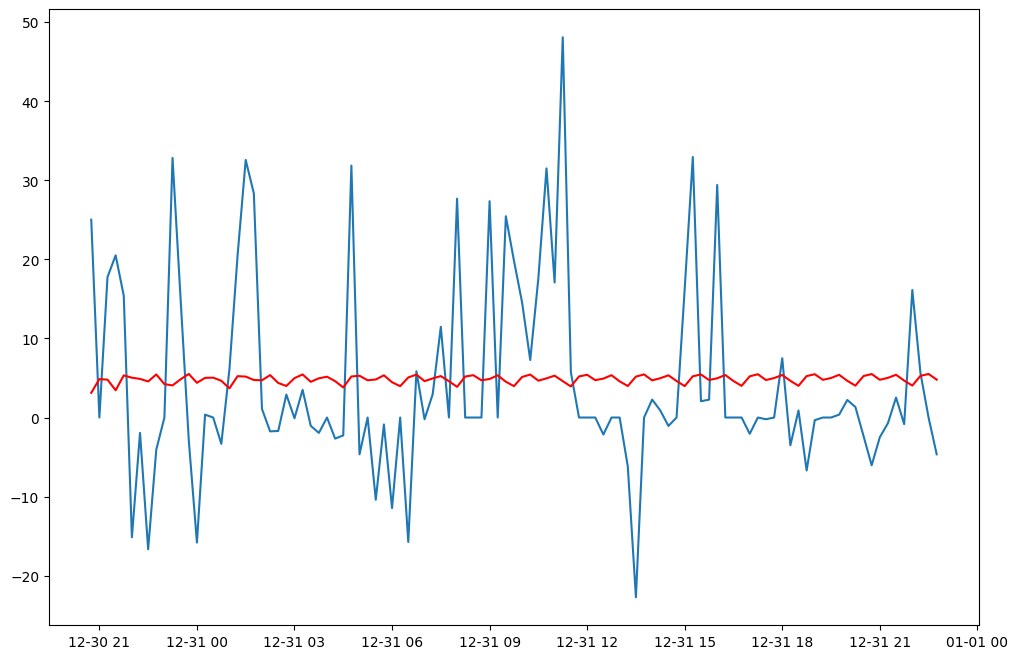

In [21]:
model = ARIMA(y, order=(2, 0, 3), seasonal_order = (1, 1, 1, 7), freq="15min")
model_fit = model.fit()

n_test = int(y.size / 1000)

train, test = y[:-n_test], y[-n_test:]

yhat = model_fit.get_forecast(steps = n_test)

plt.figure(figsize=(12, 8))
plt.plot(test.index, test, label='Imbalance')
plt.plot(test.index, yhat.predicted_mean, label='Predicted Imbalance', color='red')